# **Introduction**
In this notebook, we are developing a model that makes **sentiment analysis** for Liverpool football team players over the tweets sent during the Aston Villa-Liverpool match played on 10.05.2022.

* We will use **Twint**, which works without the need for the Twitter API, in order to shoot a large number of tweets in a short time.
* We will use the **sentiment140** dataset to train our model. The dataset contains 1,600,000 positively and negatively annoted tweets.



In [2]:
!pip3 install --user --upgrade git+https://github.com/twintproject/twint.git@origin/master#egg=twint
!pip install clean-text

  Cloning https://github.com/twintproject/twint.git (to revision origin/master) to /private/var/folders/11/j5mmp4911yj3svbv837nkx1h0000gn/T/pip-install-8_51j7tc/twint_a45ee93333fa45b688d92541b13705c8
  Running command git clone --filter=blob:none --quiet https://github.com/twintproject/twint.git /private/var/folders/11/j5mmp4911yj3svbv837nkx1h0000gn/T/pip-install-8_51j7tc/twint_a45ee93333fa45b688d92541b13705c8
  Running command git checkout -q origin/master
  Resolved https://github.com/twintproject/twint.git to commit origin/master
  Preparing metadata (setup.py) ... done

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


# Importing Dependencies

In [36]:
import nltk
import matplotlib.pyplot as plt
import re
import string
import pickle
import pandas as pd
import numpy as np
# import twint
import nest_asyncio
from cleantext import clean
import seaborn as sns
from wordcloud import WordCloud

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

import operator as op
from collections import Counter

In [4]:
# pip install twint

# Importing dataset

In [5]:
# Importing the dataset
DATASET_COLUMNS  = ["sentiment", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
dataset = pd.read_csv('training.1600000.processed.noemoticon.csv',
                      encoding=DATASET_ENCODING , names=DATASET_COLUMNS)


In [6]:
dataset.head()

,sentiment,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [7]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   sentiment  1600000 non-null  int64 
 1   ids        1600000 non-null  int64 
 2   date       1600000 non-null  object
 3   flag       1600000 non-null  object
 4   user       1600000 non-null  object
 5   text       1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [8]:
dataset.shape

(1600000, 6)

/var/folders/11/j5mmp4911yj3svbv837nkx1h0000gn/T/ipykernel_658/2987712731.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=dataset['sentiment'], palette=['red', 'green'])


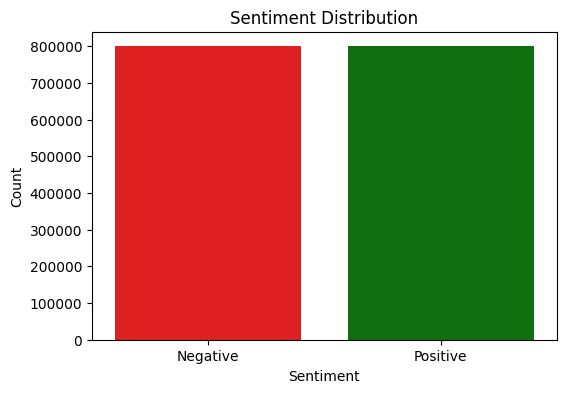

In [38]:
# Sentiment Distribution (Bar Plot)**
plt.figure(figsize=(6, 4))
sns.countplot(x=dataset['sentiment'], palette=['red', 'green'])
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.title("Sentiment Distribution")
plt.show()

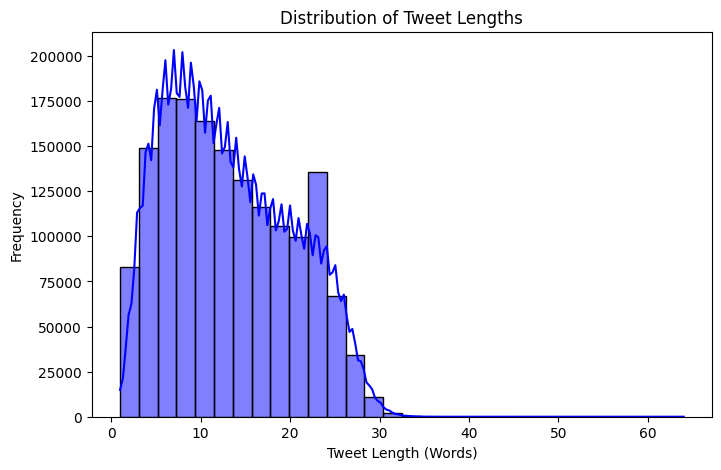

In [39]:
#Tweet Length Distribution (Histogram)**
dataset['text_length'] = dataset['text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(8, 5))
sns.histplot(dataset['text_length'], bins=30, kde=True, color='blue')
plt.xlabel("Tweet Length (Words)")
plt.ylabel("Frequency")
plt.title("Distribution of Tweet Lengths")
plt.show()

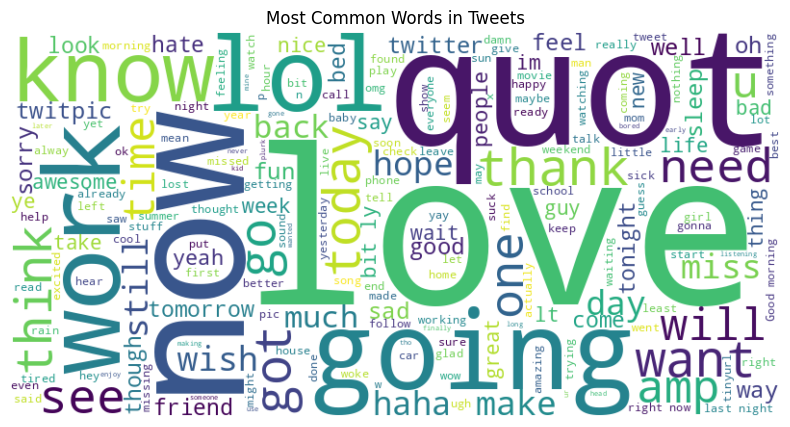

In [40]:
# Word Cloud of Most Common Words**
text_corpus = " ".join(dataset['text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_corpus)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Most Common Words in Tweets")
plt.show()

/var/folders/11/j5mmp4911yj3svbv837nkx1h0000gn/T/ipykernel_658/1679638002.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette="viridis")


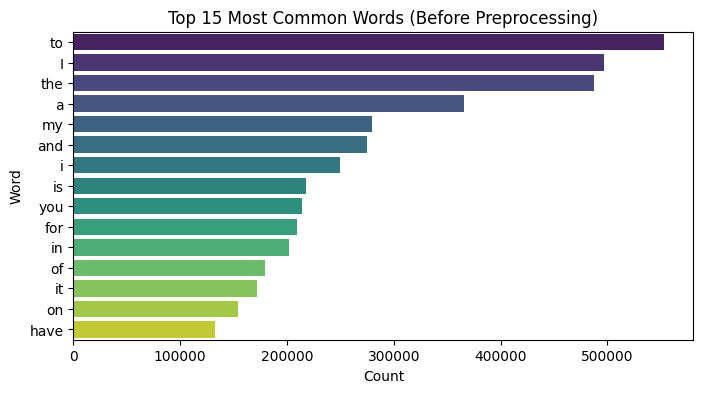

In [41]:
# Top 15 Most Common Words (Before Preprocessing)**
word_counts = Counter(text_corpus.split())
common_words = word_counts.most_common(15)

words, counts = zip(*common_words)
plt.figure(figsize=(8, 4))
sns.barplot(x=list(counts), y=list(words), palette="viridis")
plt.xlabel("Count")
plt.ylabel("Word")
plt.title("Top 15 Most Common Words (Before Preprocessing)")
plt.show()

# Text Preprocess

In [10]:
stopwords = nltk.corpus.stopwords.words('english')
lemmatizer = WordNetLemmatizer()

def preprocess(texts):
    clean_tweets = []
    
    for tweet in texts:
        tweet = tweet.lower()
        # it will remove the old style retweet text "RT"
        tweet = re.sub(r'^RT[\s]+', '', tweet)

        # it will remove hyperlinks
        tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)

        # it will remove emojis
        tweet = clean(tweet, no_emoji=True)

        # it will remove the word that starting with #
        tweet = " ".join(filter(lambda x:x[0]!='#', tweet.split()))

        # it will remove the word that starting with @
        tweet = " ".join(filter(lambda x:x[0]!='@', tweet.split()))

        # it will remove single numeric terms in the tweet. 
        tweet = re.sub(r'[0-9]', '', tweet)

        # it will remove punctuation
        tweet = tweet.translate(str.maketrans('', '', string.punctuation))

        #remove the words 2 or less characters
        tweet = re.sub(r'\b\w{1,2}\b', '', tweet)

        # it will remove multiple spaces
        tweet = re.sub(' +', ' ', tweet)
        
        tweetwords = ''
        
        for word in tweet.split():
            
            if word not in stopwords:
                root_word = lemmatizer.lemmatize(word)
                tweetwords += (root_word+' ')
                   
        clean_tweets.append(tweetwords)   
    
    return clean_tweets

processedtext = preprocess(text)

# Splitting the Data

In [11]:
X_train, X_test, y_train, y_test = train_test_split(processedtext, sentiment,
                                                    test_size = 0.1, random_state = 0)

# Vectoriser

In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
X_train_transformed = vectorizer.fit_transform(X_train)
print('Vectorizer fitted.')
print('No. of feature_words: ', len(vectorizer.get_feature_names_out()))


Vectorizer fitted.
No. of feature_words:  500000


In [13]:
print(type(X_train))

<class 'list'>


In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:

X_train = vectorizer.transform(X_train)
X_test  = vectorizer.transform(X_test)

print(f'Data Transformed.')

Data Transformed.


# Creating and Evaluating Models

In [16]:
def model_Evaluate(model):
    
    # Predict values for Test dataset
    y_pred = model.predict(X_test)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

**Logistic Regression Model**

              precision    recall  f1-score   support

           0       0.81      0.78      0.79     79738
           1       0.79      0.82      0.80     80262

    accuracy                           0.80    160000
   macro avg       0.80      0.80      0.80    160000
weighted avg       0.80      0.80      0.80    160000



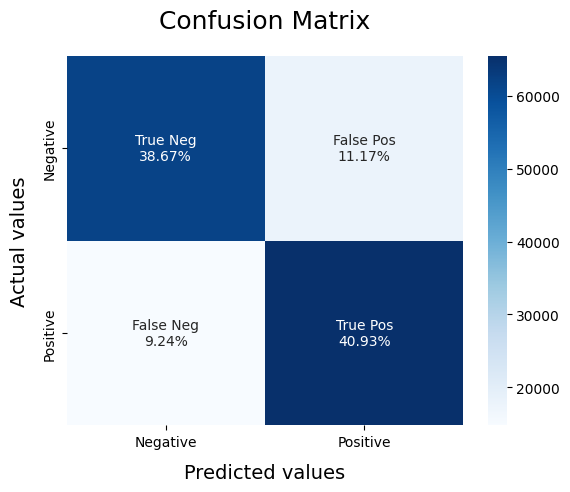

In [17]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)

In [18]:
# from sklearn.feature_extraction.text import TfidfVectorizer

# vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=500000, smooth_idf=False)
# X_train = vectorizer.fit_transform(X_train)
# X_test = vectorizer.transform(X_test)


Naive Bayes Model Evaluation:
              precision    recall  f1-score   support

           0       0.77      0.79      0.78     79738
           1       0.78      0.76      0.77     80262

    accuracy                           0.77    160000
   macro avg       0.77      0.77      0.77    160000
weighted avg       0.77      0.77      0.77    160000



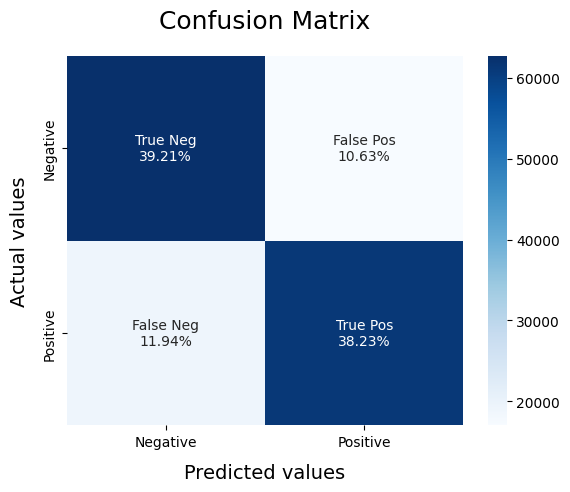

In [19]:
# Initialize and train Naive Bayes model
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

# Model evaluation function
def model_evaluate(model):
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))

    # Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)
    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)

    sns.heatmap(cf_matrix, annot=labels, cmap='Blues', fmt='',
                xticklabels=categories, yticklabels=categories)

    plt.xlabel("Predicted values", fontdict={'size': 14}, labelpad=10)
    plt.ylabel("Actual values", fontdict={'size': 14}, labelpad=10)
    plt.title("Confusion Matrix", fontdict={'size': 18}, pad=20)
    plt.show()

# Evaluate Naive Bayes Model
print("Naive Bayes Model Evaluation:")
model_evaluate(nb_model)


Deep Learning Models

In [26]:
pip install gensim


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 1.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 kB 1.2 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.3/39.3 MB 735.8 kB/s eta 0:00:0000:010:01m
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.0
    Uninstalling scipy-1.14.0:
      Successfully uninstalled scipy-1.14.0

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [28]:
import numpy as np
import gensim.downloader as api
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout


# Load GloVe Twitter embeddings (100D)
glove_vectors = api.load("glove-twitter-100")

# Set vocabulary size
MAX_VOCAB_SIZE = 50000  
embedding_dim = 100  
embedding_matrix = np.zeros((MAX_VOCAB_SIZE, embedding_dim))

# Fill the embedding matrix with GloVe vectors
for word, i in tokenizer.word_index.items():
    if i < MAX_VOCAB_SIZE and word in glove_vectors:
        embedding_matrix[i] = glove_vectors[word]


In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout

# Create an embedding layer with pretrained weights
embedding_layer = Embedding(input_dim=MAX_VOCAB_SIZE, 
                            output_dim=embedding_dim, 
                            weights=[embedding_matrix], 
                            input_length=MAX_SEQ_LENGTH, 
                            trainable=False)  # Freeze embeddings

# Define the Bidirectional LSTM model
model = Sequential([
    embedding_layer,
    Bidirectional(LSTM(64, return_sequences=True, input_shape=(MAX_SEQ_LENGTH, embedding_dim))),  # <-- FIXED
    Dropout(0.2),
    Bidirectional(LSTM(32)),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Force TensorFlow to allocate parameters
model.build(input_shape=(None, MAX_SEQ_LENGTH))

# Print model summary
model.summary()


/Users/zubair/.pyenv/versions/3.10.11/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 100, 100)       │     5,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 100, 128)       │        84,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,126,753 (19.56 MB)

 Trainable params: 126,753 (495.13 KB)

 Non-trainable params: 5,000,000 (19.07 MB)

In [31]:
history = model.fit(X_train, np.array(y_train), 
                    epochs=5, 
                    batch_size=128,  # Larger batch size for faster training
                    validation_data=(X_test, np.array(y_test)))


Epoch 1/5
11250/11250 ━━━━━━━━━━━━━━━━━━━━ 2525s 224ms/step - accuracy: 0.7625 - loss: 0.4892 - val_accuracy: 0.7873 - val_loss: 0.4505
Epoch 2/5
11250/11250 ━━━━━━━━━━━━━━━━━━━━ 2544s 226ms/step - accuracy: 0.7900 - loss: 0.4460 - val_accuracy: 0.7952 - val_loss: 0.4384
Epoch 3/5
11250/11250 ━━━━━━━━━━━━━━━━━━━━ 2381s 212ms/step - accuracy: 0.7972 - loss: 0.4344 - val_accuracy: 0.7970 - val_loss: 0.4340
Epoch 4/5
11250/11250 ━━━━━━━━━━━━━━━━━━━━ 2572s 229ms/step - accuracy: 0.8012 - loss: 0.4274 - val_accuracy: 0.7979 - val_loss: 0.4328
Epoch 5/5
11250/11250 ━━━━━━━━━━━━━━━━━━━━ 2804s 249ms/step - accuracy: 0.8048 - loss: 0.4207 - val_accuracy: 0.7992 - val_loss: 0.4310


In [32]:
loss, accuracy = model.evaluate(X_test, np.array(y_test))
print(f"Test Accuracy: {accuracy:.4f}, Test Loss: {loss:.4f}")


5000/5000 ━━━━━━━━━━━━━━━━━━━━ 118s 23ms/step - accuracy: 0.7991 - loss: 0.4303
Test Accuracy: 0.7992, Test Loss: 0.4310


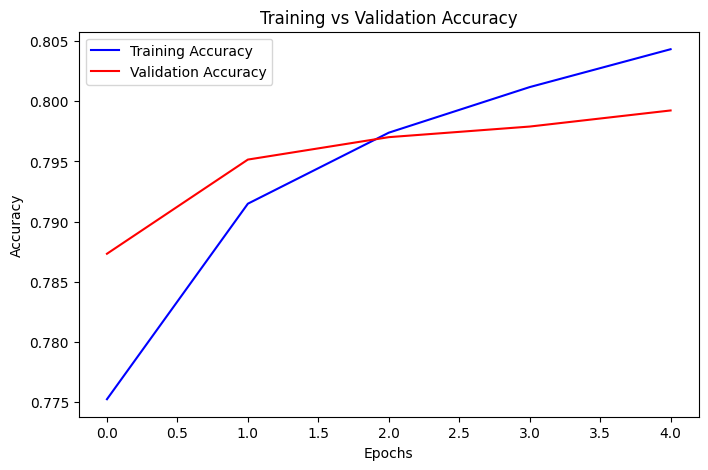

In [33]:
import matplotlib.pyplot as plt

# Extract accuracy from history
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')

# Labels & Title
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.show()


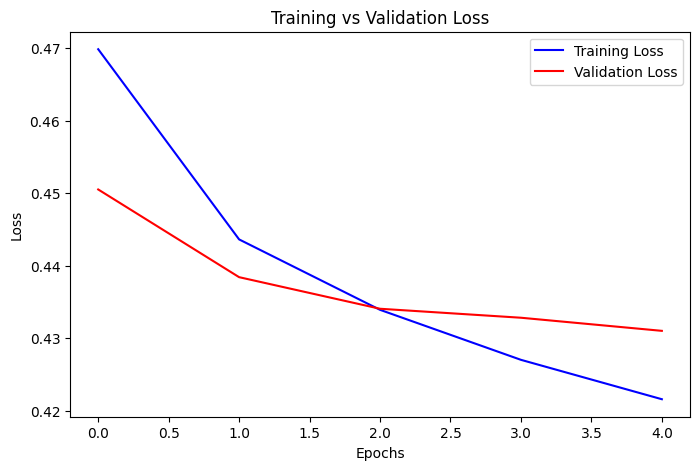

In [34]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')

# Labels & Title
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()
